## Loading Libs

In [24]:
import transformers

from transformers import BertForTokenClassification, BertTokenizer
import torch
import numpy as np
import pandas as pd

## Loading dataset

In [5]:
from datasets import load_dataset

dataset = load_dataset("lener_br")

Reusing dataset lener_br (/home/caiotulio/.cache/huggingface/datasets/lener_br/lener_br/1.0.0/4a8c97e6813b5c2d85a50faf0a3e6c24ea82f4a9044e6e9e8b24997d27399382)


In [6]:
NER_tags = ["O", "B-ORGANIZACAO", "I-ORGANIZACAO", "B-PESSOA", "I-PESSOA", "B-TEMPO", "I-TEMPO", "B-LOCAL", "I-LOCAL", "B-LEGISLACAO", "I-LEGISLACAO", "B-JURISPRUDENCIA", "I-JURISPRUDENCIA"]
num_labels = len(NER_tags)

## Loading model checkpoint for tokenizer and for model weight initialization

In [7]:
PRE_TRAINED_MODEL = 'neuralmind/bert-base-portuguese-cased'

In [8]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL)

In [9]:
model = BertForTokenClassification.from_pretrained(
    PRE_TRAINED_MODEL,
    num_labels=num_labels,
)

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model check

In [10]:
model.num_labels

13

# Data exploration

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams

from matplotlib import rc

In [12]:
sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

torch.manual_seed(RANDOM_SEED)

## Analysing number of labels

In [13]:
tags = np.concatenate(dataset['train'][:]['ner_tags'])

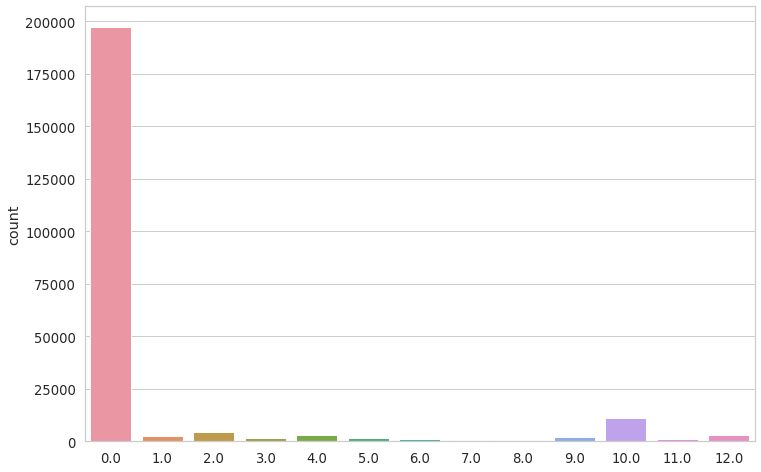

In [14]:
sns.countplot(tags)

In [15]:
identified_tags = list(filter(lambda t: t > 0, tags))

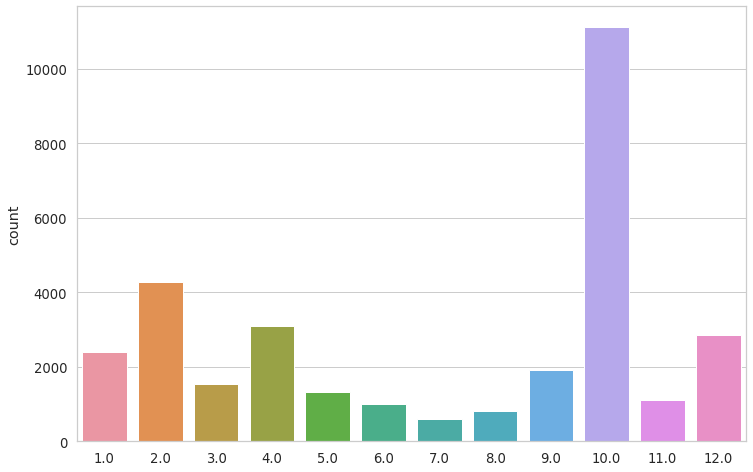

In [16]:
sns.countplot(identified_tags)

## Analysing sentence size

In [17]:
def get_length(tokens):
    return [len(s) for s in tokens]

In [18]:
def retokenize(tokens):
    retokenized = []
    for token in tokens:
        s = " ".join(token)
        tok = tokenizer.tokenize(s)
        retokenized.append(tok)
    return retokenized

In [21]:
tokens = dataset['train'][:]['tokens']
tokens = retokenize(tokens)
lengths = get_length(tokens)

In [ ]:
teste = list(filter(lambda l: l > 200,lengths))

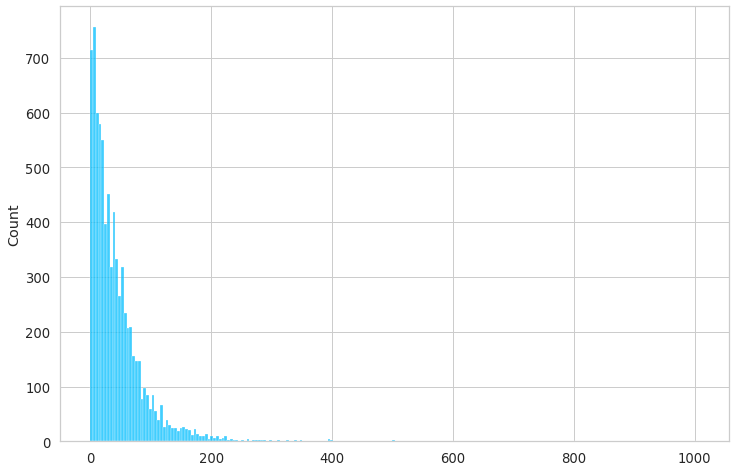

In [22]:
sns.histplot(lengths)

In [40]:
df = pd.DataFrame(lengths)

In [42]:
len(df)

7828

In [43]:
df.quantile(0.99)

0    223.0
Name: 0.99, dtype: float64

In [39]:
0.01*len(df)

NameError: name 'df' is not defined

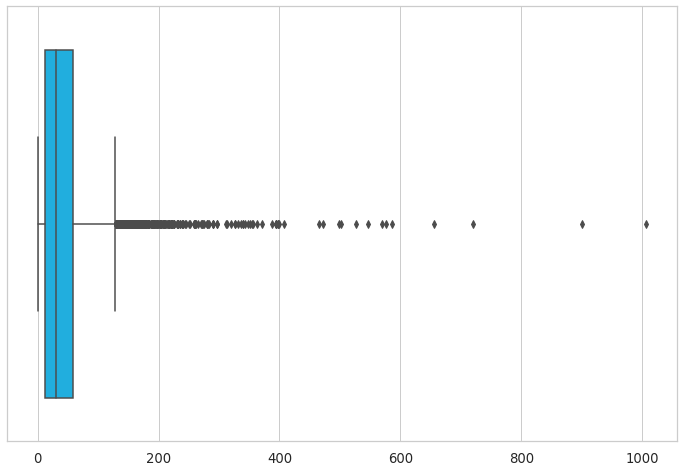

In [23]:
sns.boxplot(lengths)

In [ ]:
longer_sentences = list(filter(lambda t: len(t) > 512, tokens)) # Bert maximum sentence size

In [ ]:
" ".join(longer_sentences[0])

In [ ]:
TOKEN_SIZE_THRESHOLD = 256

In [ ]:
def categorize(token):
    return 0 if len(token) < TOKEN_SIZE_THRESHOLD else 1

In [ ]:
tokens_by_size = list(map(categorize, tokens))
larger_than_threshold = np.count_nonzero(tokens_by_size)
smaller_than_threshold = len(tokens_by_size) - larger_than_threshold

print(f"Tokens menores que {TOKEN_SIZE_THRESHOLD}: {smaller_than_threshold}; Maiores que {TOKEN_SIZE_THRESHOLD}: {larger_than_threshold}")

In [ ]:
print(f"A maior sentença tem comprimento {np.max(lengths)}") 

A esmagadora maioria das sentenças tem tamanho menor do que 256, acho que dá só pra descartar essas maiores. (analise meio porca, mas enfim)

## Testing out the tokenizer

In [ ]:
sample = dataset['test'][10] # numero aleatório
sentence = sample['tokens']
tags = sample['ner_tags']
print(sentence)
print(tags)

In [ ]:
tokenizer.tokenize(" ".join(sentence))

(O output do tokenizer do bertimbau é diferente da tokenização fornecida pelo dataset. O dataset aparentemente fez um tokenização baseado em espaços. Um problema de tokenizar do zero seria lidar com pontuação estranha de texto jurídico)

# Pipeline to pass a single sentence to the model

In [ ]:
tokenized_input = sample['tokens']
tokenized_input

In [ ]:
ids = tokenizer.convert_tokens_to_ids(tokenized_input)

In [ ]:
ids

In [ ]:
tokenizer.decode(ids) # Varios unknows

In [ ]:
input_tensor = torch.tensor([ids])

In [ ]:
output = model(input_tensor)

In [ ]:
softmax = torch.nn.Softmax()

In [ ]:
output.logits[0]

## Comparing retokenization with just passing the sentences

In [ ]:
tokenized_input

In [ ]:
tokenizer.decode(tokenizer.convert_tokens_to_ids(tokenized_input))

In [ ]:
tokenizer.decode(
        tokenizer.convert_tokens_to_ids(
            tokenizer.tokenize(
                " ".join(tokenized_input)
            )
        )
)

In [ ]:
def encode_decode(tokens):
    ids = tokenizer.convert_tokens_to_ids(tokens)
    return tokenizer.decode(ids)

In [ ]:
def vanilla_approach(tokens):
    sentence = " ".join(tokens)
    return encode_decode(sentence)

In [ ]:
def lazy_approach(tokens):
    return encode_decode(sentence)

In [ ]:
from collections import defaultdict

In [ ]:
def count_unknowns(data):
    """
    Compares the ammount of unknow tokens from two different tokenizations approaches: the vanilla one (retokenizing the data
    in the dataset) and the lazy one (just using the pretokenized data)
    """
    freq = defaultdict()
    unk_vanilla = 0
    unk_lazy = 0
    total_tokens = 0
    for i in range(len(data)):
        sample = data[i]['tokens']
        total_tokens += len(sample)
        lazy_decoded = lazy_approach(sample)
        vanilla_decoded = vanilla_approach(sample)
        unk_lazy += lazy_decoded.count('[UNK]')
        unk_vanilla += vanilla_decoded.count('[UNK]')
    return unk_vanilla, unk_lazy, total_tokens
        

In [ ]:
count_unknowns(dataset['train'])

In [ ]:
100 * 54796/229277

23% dos tokens são perdidos no processo lazy :O